In [124]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, LinearSVC
import shap
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import matthews_corrcoef, classification_report, roc_auc_score
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

<h1 style="text-align:center">Dataset Loading</h1>

In [125]:
def read_data():
    df = pd.read_csv("./input/telomere_health.csv")
    df = df.drop(
        columns=[
            "socioeconomic_status",
            "bp",
            "bmi_category",
            "hr_category",
            "rr_category",
            "health_condition",
            "education_cohort",
            "marital_status",
        ]
    )
    return df

<h1 style="text-align:center">Data Preprocessing</h1>

In [126]:
def categorical_to_numeric(df, column, mapping, regex=False):
    df[column] = df[column].replace(mapping, regex=regex)


def fill_na(df, column, default):
    fill_value = np.nan
    if default == "median":
        fill_value = df[column].median()
    elif default == "mode":
        fill_value = df[column].mode()[0]

    df[column] = df[column].fillna(fill_value)

In [127]:
def preprocess_data(df):

    categorical_to_numeric(
        df,
        "cigarette_smoking",
        {
            "No information": np.nan,
            "Former Smoker": np.nan,
            "Never Smoker": 0,
            "Occasional Smoker": 1,
            "Regular Smoker": 2,
        },
    )

    categorical_to_numeric(
        df,
        "physical_activity_cohort",
        {
            "No information": np.nan,
            "Sedentary (Inactive)": 0,
            "Minimally Active": 1,
            "Lightly Active": 2,
            "Moderately Active": 3,
            "Highly Active": 4,
        },
    )

    categorical_to_numeric(
        df,
        "alcohol_drinking",
        {
            "No information": np.nan,
            "Former Drinker": np.nan,
            "Never Drinker": 0,
            "Occasional Drinker": 1,
            "Moderate Drinker": 2,
            "Heavy Drinker": 3,
        },
    )

    categorical_to_numeric(
        df,
        "bp_category",
        {
            "No information": np.nan,
            "Hypotension (Low BP)": 0,
            "Normal BP": 1,
            "Elevated BP": 2,
            "Hypertension Stage 1": 3,
            "Hypertension Stage 2": 4,
            "Hypertensive Crisis": 5,
        },
    )

    categorical_to_numeric(
        df,
        "cardiovascular_disease_diagnosis",
        {
            "^No known*": 0,
            "^Non-cardiovascular*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "cancer_diagnosis",
        {
            "^Clinically Healthy*": 0,
            "^Non-oncologic*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "depression_anxiety_diagnosis",
        {
            "^No Known*": 0,
            "^Anxiety and/or*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "allergy_diagnosis",
        {
            "^No Diagnosed*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "diabetes_diagnosis",
        {
            "^No known diagnosis*": 0,
            "^Diagnosed with*": 1,
        },
        regex=True,
    )

    df["hr"] = pd.to_numeric(df["hr"], errors="coerce")
    df["rr"] = pd.to_numeric(df["rr"], errors="coerce")

    fill_na(df, "hr", "median")
    fill_na(df, "rr", "median")
    fill_na(df, "bmi", "median")
    fill_na(df, "alcohol_drinking", "mode")
    fill_na(df, "cigarette_smoking", "mode")
    fill_na(df, "bp_category", "mode")
    fill_na(df, "physical_activity_cohort", "mode")

    df = pd.get_dummies(df, columns=["sex"])

    return df

<h1 style="text-align:center">Model Training</h1>

In [158]:
def train_model(df, to_predict, rs=0):
    y = df.pop(to_predict)
    X = df

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=rs
    )

    # Feature Selection, Scaling and Training Pipeline
    pipeline = Pipeline(
        [
            (
                "selector",
                SelectFromModel(LinearSVC(penalty="l1", dual=False, max_iter=10000)),
            ),
            ("scaler", StandardScaler()),
            ("lsvc", SVC(kernel="linear", probability=True, class_weight="balanced")),
        ]
    )

    # Training Model
    pipeline.fit(X_train, y_train)

    # Pipeline Partitioning
    selector = pipeline.named_steps["selector"]
    scaler = pipeline.named_steps["scaler"]
    lsvc_model = pipeline.named_steps["lsvc"]

    # Feature Variance, Weights
    selected_indeces = selector.get_support()

    features_names = pd.Series(X_train.columns[selected_indeces])
    feature_names = [name.replace("_", " ").upper() for name in features_names]

    # feature_variances = pd.Series(selector.variances_[selected_indeces])
    feature_weights = pd.Series(pipeline.named_steps["lsvc"].coef_[0])

    feature_report = pd.DataFrame(
        data={
            "Selected Features": features_names,
            # "Variances": feature_variances,
            "Weights": feature_weights,
        }
    )

    feature_report = feature_report.sort_values(by="Weights", key=abs, ascending=False)
    feature_report = feature_report.reset_index(drop=True)

    # Feature Shapley Values
    X_train_selected = selector.transform(X_train)
    X_train_transformed = scaler.transform(X_train_selected)

    X_test_transformed = selector.transform(X_test)
    X_test_transformed = scaler.transform(X_test_transformed)

    explainer = shap.LinearExplainer(lsvc_model, X_train_transformed)
    shap_values = explainer.shap_values(X_test_transformed)

    def shap_plot():
        shap.plots.violin(
            shap_values,
            features=X_test_transformed,
            feature_names=feature_names,
        )

    # Model Metrics
    y_pred = pipeline.predict(X_test)
    y_probs = lsvc_model.predict_proba(X_test_transformed)

    # Compute Cross-Validation Accuracy
    cv_scores = cross_val_score(pipeline, X_test, y_test, cv=5, scoring="accuracy")
    cv_accuracy = round(np.mean(cv_scores) * 100, 2)

    # Compute Matthew's Coefficient
    matthews_coeff = matthews_corrcoef(y_test, y_pred)
    matthews_coeff = round(matthews_coeff * 100, 2)

    # Test ROC-AUC
    auc_score = roc_auc_score(y_test, y_probs[:, 1])
    auc_score = round(auc_score * 100, 2)

    # Generate Classification Report
    model_report = classification_report(
        y_test, y_pred, target_names=["No Disease", "Disease"], output_dict=True
    )
    model_report = pd.DataFrame(model_report).drop("accuracy", axis=1).T.round(2)

    return (
        cv_accuracy,
        matthews_coeff,
        auc_score,
        feature_report,
        shap_plot,
        model_report,
    )

<h1 style="text-align:center">Cardiovascular Disease Prediction 🩺</h1>

In [159]:
cvd_df = read_data()
cvd_preprocessed = preprocess_data(cvd_df)


(
    cvd_cv_accuracy,
    cvd_matthews_coeff,
    cvd_auc_score,
    cvd_feature_report,
    cvd_shap_plot,
    cvd_model_report,
) = train_model(cvd_preprocessed, "cardiovascular_disease_diagnosis", 958784)

<h1 style="text-align:center">Features and Model Metrics</h1>

<h2>5-Fold Accuracy</h2>

In [161]:
print(f"5-Fold Cross-Validation Accuracy: {cvd_cv_accuracy}")

5-Fold Cross-Validation Accuracy: 86.13


<h2>Precission, Recall, F1 Scores</h2>

In [162]:
print(cvd_model_report)

              precision  recall  f1-score  support
No Disease         0.96    0.71      0.82     91.0
Disease            0.53    0.91      0.67     32.0
macro avg          0.74    0.81      0.74    123.0
weighted avg       0.84    0.76      0.78    123.0


<h2>Matthew's Coefficient </h2>

In [163]:
print(f"Matthew's Coefficient: {cvd_matthews_coeff}")

Matthew's Coefficient: 54.76


<h2>Area Under the Curve of the Receiver Operating Characteristic (ROC-AUC)</h2>

In [164]:
print(f"Test ROC-AUC: {cvd_auc_score}")

Test ROC-AUC: 89.84


<h2>Selected Features' Variances & Weights</h2>

In [165]:
cvd_feature_report

,Selected Features,Weights
0,age,1.130441
1,bp_category,0.546081
2,physical_activity_cohort,-0.393925
3,depression_anxiety_diagnosis,0.310690
4,rr,0.200329
5,telomere_length,-0.178838
6,cancer_diagnosis,0.151873
7,allergy_diagnosis,-0.100684
8,alcohol_drinking,0.064039
9,diabetes_diagnosis,0.049683


<h2>Feature Shapley Values</h2>

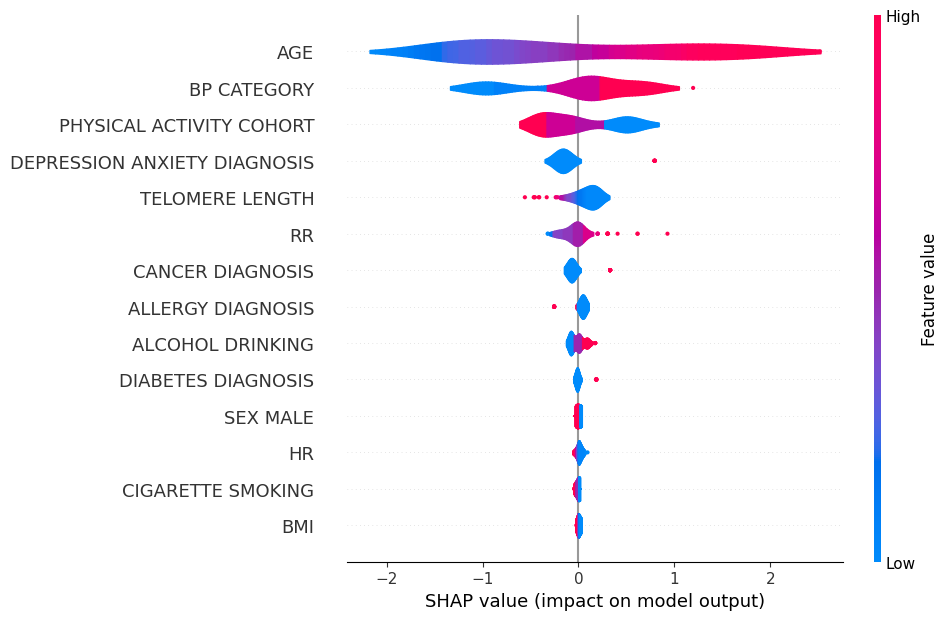

In [166]:
cvd_shap_plot()

<h1 style="text-align:center">Cancer Prediction 🎗</h1>

In [167]:
cancer_df = read_data()
cancer_preprocessed = preprocess_data(cancer_df)

(
    cancer_cv_accuracy,
    cancer_matthews_coeff,
    cancer_auc_score,
    cancer_feature_report,
    cancer_shap_plot,
    cancer_model_report,
) = train_model(cancer_preprocessed, "cancer_diagnosis", rs=5349939)

<h1 style="text-align:center">Features and Model Metrics</h1>

<h2>10-Fold Accuracy</h2>

In [168]:
print(f"5-Fold Cross-Validation Accuracy: {cancer_cv_accuracy}")

5-Fold Cross-Validation Accuracy: 87.03


<h2>Precission, Recall, F1 Scores</h2>

In [169]:
print(cancer_model_report)

              precision  recall  f1-score  support
No Disease         0.98    0.77      0.86    113.0
Disease            0.24    0.80      0.36     10.0
macro avg          0.61    0.78      0.61    123.0
weighted avg       0.92    0.77      0.82    123.0


<h2>Matthew's Coefficient </h2>

In [170]:
print(f"Matthew's Coefficient: {cancer_matthews_coeff}")

Matthew's Coefficient: 34.83


<h2>Area Under the Curve of the Receiver Operating Characteristic (ROC-AUC)</h2>

In [171]:
print(f"Test ROC-AUC: {cancer_auc_score}")

Test ROC-AUC: 86.37


<h2>Selected Features' Variances & Weights</h2>

In [174]:
cancer_feature_report

,Selected Features,Weights
0,bmi,-1.005533
1,telomere_length,0.610002
2,depression_anxiety_diagnosis,0.342874
3,sex_Male,-0.329523
4,bp_category,0.306354
5,alcohol_drinking,0.263875
6,diabetes_diagnosis,0.244499
7,physical_activity_cohort,-0.143019
8,age,0.124088
9,cardiovascular_disease_diagnosis,-0.072945


<h2>Feature Shapley Values</h2>

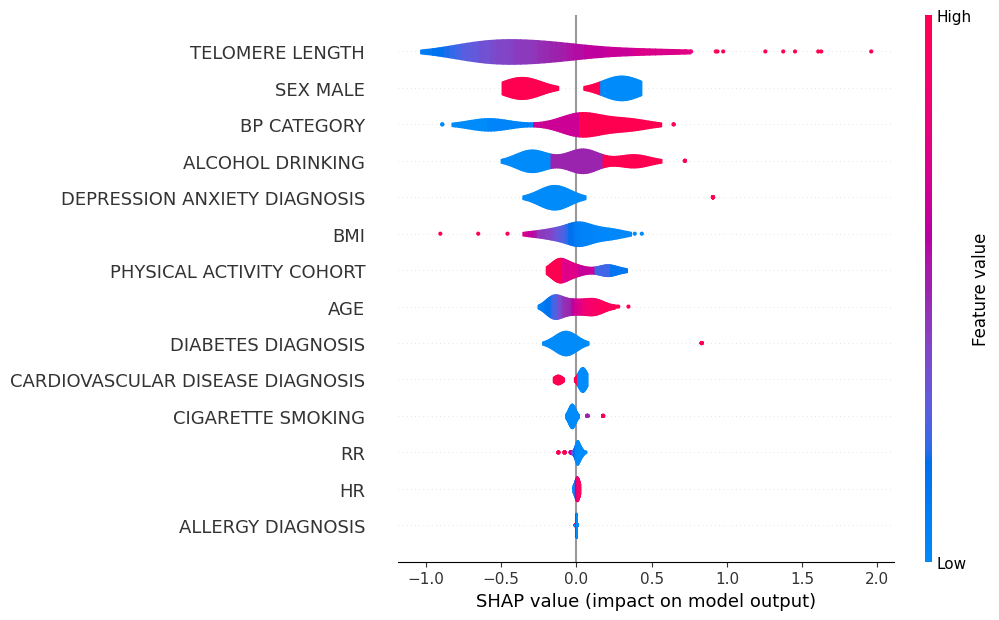

In [175]:
cancer_shap_plot()

<h1 style="text-align:center">Diabetes Mellitus Prediction 💉</h1>

In [183]:
diabetes_df = read_data()
diabetes_preprocessed = preprocess_data(diabetes_df)

(
    diabetes_cv_accuracy,
    diabetes_matthews_coeff,
    diabetes_auc_score,
    diabetes_feature_report,
    diabetes_shap_plot,
    diabetes_model_report,
) = train_model(diabetes_preprocessed, "diabetes_diagnosis", rs=20056)

<h1 style="text-align:center">Features and Model Metrics</h1>

<h2>10-Fold Accuracy</h2>

In [185]:
print(f"5-Fold Cross-Validation Accuracy: {diabetes_cv_accuracy}")

5-Fold Cross-Validation Accuracy: 91.03


<h2>Precission, Recall, F1 Scores</h2>

In [186]:
print(diabetes_model_report)

              precision  recall  f1-score  support
No Disease         0.98    0.57      0.72    113.0
Disease            0.16    0.90      0.26     10.0
macro avg          0.57    0.73      0.49    123.0
weighted avg       0.92    0.59      0.68    123.0


<h2>Matthew's Coefficient </h2>

In [187]:
print(f"Matthew's Coefficient: {diabetes_matthews_coeff}")

Matthew's Coefficient: 25.53


<h2>Area Under the Curve of the Receiver Operating Characteristic (ROC-AUC)</h2>

In [188]:
print(f"Test ROC-AUC: {diabetes_auc_score}")

Test ROC-AUC: 70.53


<h2>Selected Features' Variances & Weights</h2>

In [189]:
diabetes_feature_report

,Selected Features,Weights
0,bmi,1.048706
1,age,0.833879
2,rr,-0.448492
3,depression_anxiety_diagnosis,0.441116
4,sex_Male,-0.318773
5,cancer_diagnosis,0.289245
6,physical_activity_cohort,0.258328
7,cigarette_smoking,-0.256882
8,alcohol_drinking,-0.174373
9,hr,0.066199


<h2>Feature Shapley Values</h2>

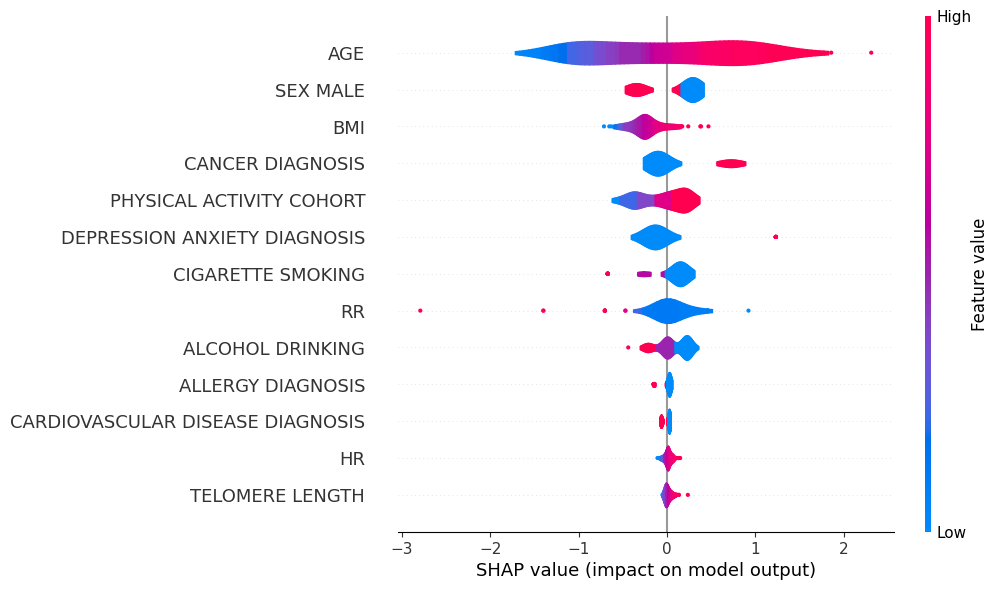

In [190]:
diabetes_shap_plot()

<h1 style="text-align:center">Depression/Anxiety Prediction 🧠</h1>

In [211]:
depression_anxiety_df = read_data()
depression_anxiety_preprocessed = preprocess_data(depression_anxiety_df)

(
    depression_anxiety_cv_accuracy,
    depression_anxiety_matthews_coeff,
    depression_anxiety_auc_score,
    depression_anxiety_feature_report,
    depression_anxiety_shap_plot,
    depression_anxiety_model_report,
) = train_model(
    depression_anxiety_preprocessed, "depression_anxiety_diagnosis", rs=87083
)

<h1 style="text-align:center">Features and Model Metrics</h1>

<h2>10-Fold Accuracy</h2>

In [205]:
print(f"5-Fold Cross-Validation Accuracy: {depression_anxiety_cv_accuracy}")

5-Fold Cross-Validation Accuracy: 93.47


<h2>Precission, Recall, F1 Scores</h2>

In [206]:
print(depression_anxiety_model_report)

              precision  recall  f1-score  support
No Disease         1.00    0.71      0.83    112.0
Disease            0.26    1.00      0.41     11.0
macro avg          0.63    0.86      0.62    123.0
weighted avg       0.93    0.74      0.80    123.0


<h2>Matthew's Coefficient </h2>

In [207]:
print(f"Matthew's Coefficient: {depression_anxiety_matthews_coeff}")

Matthew's Coefficient: 42.75


<h2>Area Under the Curve of the Receiver Operating Characteristic (ROC-AUC)</h2>

In [208]:
print(f"Test ROC-AUC: {depression_anxiety_auc_score}")

Test ROC-AUC: 93.83


<h2>Selected Features' Variances & Weights</h2>

In [209]:
depression_anxiety_feature_report

,Selected Features,Weights
0,age,-1.136884
1,cigarette_smoking,-1.129544
2,bp_category,1.002216
3,alcohol_drinking,0.659421
4,rr,-0.360278
5,hr,-0.305759
6,physical_activity_cohort,-0.282655
7,cancer_diagnosis,0.115830
8,telomere_length,-0.113001
9,bmi,-0.104007


<h2>Feature Shapley Values</h2>

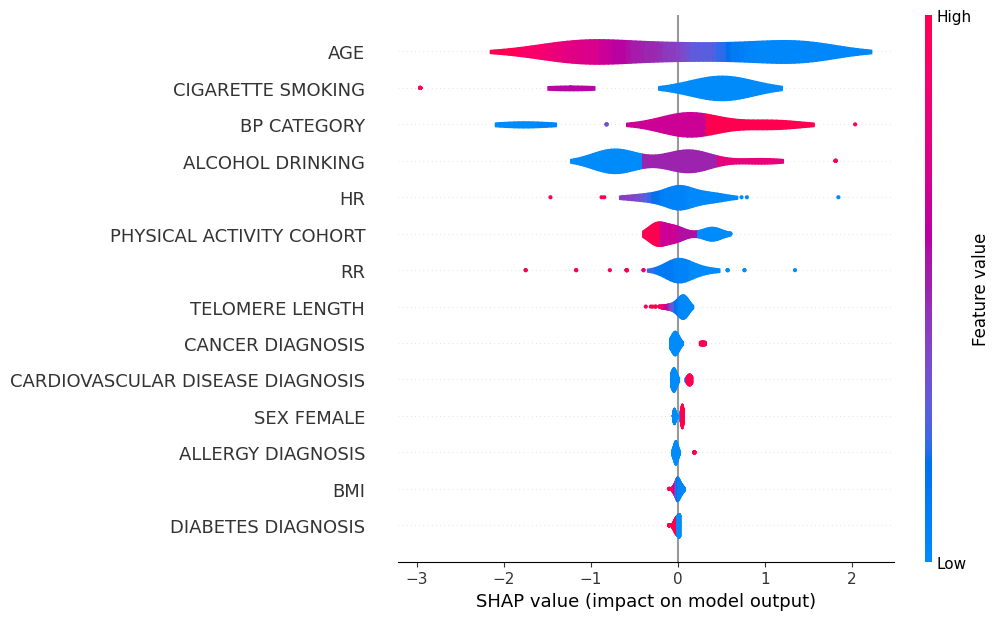

In [210]:
depression_anxiety_shap_plot()

<h1 style="text-align:center">Allergy Prediction 🚫</h1>

In [227]:
allergy_df = read_data()
allergy_preprocessed = preprocess_data(allergy_df)

(
    allergy_cv_accuracy,
    allergy_matthews_coeff,
    allergy_auc_score,
    allergy_feature_report,
    allergy_shap_plot,
    allergy_model_report,
) = train_model(allergy_preprocessed, "allergy_diagnosis", rs=76668)

<h1 style="text-align:center">Features and Model Metrics</h1>

<h2>10-Fold Accuracy</h2>

In [228]:
print(f"5-Fold Cross-Validation Accuracy: {allergy_cv_accuracy}")

5-Fold Cross-Validation Accuracy: 85.37


<h2>Precission, Recall, F1 Scores</h2>

In [229]:
print(allergy_model_report)

              precision  recall  f1-score  support
No Disease         0.92    0.65      0.76    111.0
Disease            0.13    0.50      0.21     12.0
macro avg          0.53    0.57      0.49    123.0
weighted avg       0.85    0.63      0.71    123.0


<h2>Matthew's Coefficient </h2>

In [230]:
print(f"Matthew's Coefficient: {allergy_matthews_coeff}")

Matthew's Coefficient: 9.16


<h2>Area Under the Curve of the Receiver Operating Characteristic (ROC-AUC)</h2>

In [234]:
print(f"Test ROC-AUC: {allergy_auc_score}")

Test ROC-AUC: 68.32


<h2>Selected Features' Variances & Weights</h2>

In [235]:
allergy_feature_report

,Selected Features,Weights
0,bp_category,-0.477983
1,depression_anxiety_diagnosis,0.417158
2,diabetes_diagnosis,0.317330
3,sex_Male,-0.186476
4,telomere_length,-0.146232
5,age,-0.134075
6,alcohol_drinking,0.123461
7,cancer_diagnosis,-0.102988
8,hr,0.088933
9,bmi,-0.077296


<h2>Feature Shapley Values</h2>

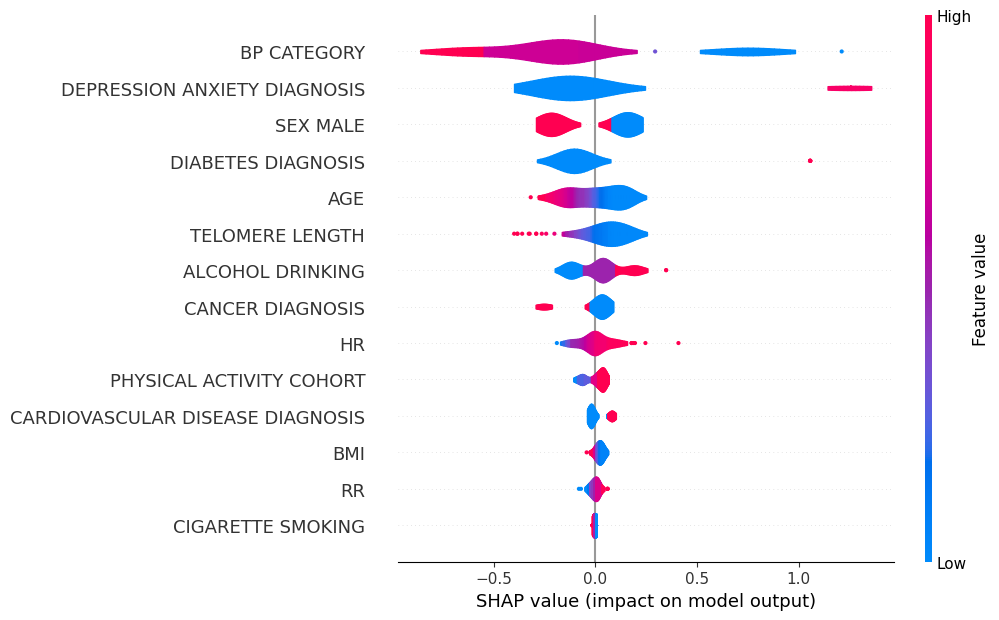

In [236]:
allergy_shap_plot()